# Focusing Data figure
Temporarily called figure 3. Could change. We want to smooth and plot bars with confidence intervals for the data in xixi's new experiments


In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [ ]:
focusing = read.csv("./rawdata/focusing2.csv")
focusing %<>% rename(Substrate = Experiment)

In [ ]:
focusing %<>% gather(Experiment,Concentration,Control, Add_ATP,Wait)
focusing$channel[focusing$Distance <= 100] <- 'left'
focusing$channel[focusing$Distance > 100 & focusing$Distance <= 220] <- 'center'
focusing$channel[focusing$Distance > 220] <- 'right'

In [ ]:
m <- function(df,m) {
    temp <- df %>%
        bootstrap(m) %>%
#          do(augment(glm(data = ., Concentration ~ ns(Distance, df = 6)),.))
         do(augment(loess(data = ., Concentration ~ Distance, span =0.5),.))
    temp
}

In [ ]:
focusing_bs <- focusing %>%
    group_by(Substrate, Experiment) %>%
    do(m(.,25))

Now we need to normalize each bootstrap sample integral to 1. We do this by sorting the distance then integrating concnetration with distances.

In [ ]:
focusing_bs$channel <- 0
focusing_bs$channel[focusing_bs$Distance <= 100] <- 'left'
focusing_bs$channel[focusing_bs$Distance > 100 & focusing_bs$Distance <= 220] <- 'center'
focusing_bs$channel[focusing_bs$Distance > 220] <- 'right'
focusing_bs$channel <- factor(focusing_bs$channel, levels = c ('left','center','right'))

In [ ]:
focusing_bs %<>% group_by(replicate,Substrate,Experiment,channel) %>% arrange(Distance) %>%
    mutate(concentration.channel.integral = t(diff(Distance)) %*% Concentration[1:(length(Concentration)-1)])
focusing_bs %<>% group_by(replicate,Substrate,Experiment,channel) %>% arrange(Distance) %>%
    mutate(.fitted.channel.integral = t(diff(Distance)) %*% .fitted[1:(length(.fitted)-1)])
focusing_bs %<>% ungroup() %>% group_by(Substrate,Experiment,replicate) %>% 
    mutate(concentration.integral = sum(concentration.channel.integral))
focusing_bs %<>% ungroup() %>% group_by(Substrate,Experiment,replicate) %>% 
    mutate(.fitted.integral = sum(.fitted.channel.integral))
# focusing_bs %<>% ungroup() %>% group_by(Experiment,replicate,channel,Substrate) %>% 
#     mutate(concentration.normalized = sum(Integral)/mean(normalized))
focusing_bs$concentration.normalized <- focusing_bs$Concentration / focusing_bs$concentration.integral
focusing_bs$.fitted.normalized <- as.vector(focusing_bs$.fitted) / as.vector(focusing_bs$.fitted.integral)
focusing_bs$.fitted.normalized.channel.integral <- as.vector(focusing_bs$.fitted.channel.integral) / as.vector(focusing_bs$.fitted.integral )
glimpse(focusing_bs)

In [ ]:
alpha <- 0.05
bs_recap <- focusing_bs %>%
    group_by(Experiment, Substrate, Distance,channel) %>% 
    summarise(lo = quantile(.fitted.normalized,alpha/2), 
              hi = quantile(.fitted.normalized,1-alpha/2), 
              smooth = mean(.fitted.normalized), 
              orig = mean(concentration.normalized))
focusing_bs %<>% group_by(Experiment, Substrate, Distance,channel) %>% 
    mutate(lo = quantile(.fitted.normalized,alpha/2), hi = quantile(.fitted.normalized,1-alpha/2))

In [ ]:
bychannel_bs <- focusing_bs %>% group_by(replicate,Substrate,Experiment,channel) %>% arrange(Distance) %>%
    summarise(Integral = t(diff(Distance)) %*% Concentration[1:(length(Concentration)-1)])
bychannel_bs %<>% ungroup() %>% group_by(Substrate,Experiment,replicate) %>% mutate(normalized = sum(Integral))
bychannel_bs %<>% ungroup() %>% group_by(Experiment,replicate,channel,Substrate) %>% mutate(concentration = sum(Integral)/mean(normalized))
check <- bychannel_bs %>% ungroup() %>% group_by(Substrate,Experiment,replicate) %>% summarise(sum = sum(concentration))
head(check)

In [ ]:
bychannel_recap <- bs_recap %>% 
    group_by(channel,Substrate,Experiment) %>% 
    summarise(orig = sum(orig), smooth = sum(smooth), lo = sum(lo), hi = sum(hi))

In [ ]:
# glimpse(bychannel_recap)
write.csv(filter(bychannel_recap, Experiment !="Wait"),"./bychannel_recap.csv")

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 2)
integrated <- ggplot(data = filter(bychannel_recap, Experiment !="Wait") , 
                     aes(x=channel, y= smooth,fill = Experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Channel") +
    ylab("Integrated N.F.I") +
    facet_grid(. ~ Substrate,
        labeller = labeller(Substrate =c(DG = 'D-Glucose',LG = 'L-Glucose'))) +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) + 
    annotate("rect", xmin = 0.5, xmax = 1.5, ymin = 0, ymax = +.0055, alpha = .2) +
    annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
    geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lo,ymax = hi ),position = position_dodge(1), width = 0) +
scale_fill_brewer(palette = 'Set1',labels = c("Control","ATP in\ncentral channel"))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("DG","LG"), Experiment = c("Control","Add_ATP"), 
                      ann.x = c(0.75, 0.75), ann.xend = c(1.25,1.25), ann.y = c(0.0033, 0.0037),
                      ann.yend = c(0.0033,0.0037), ann.text = c("***"," n.s."), ann.textoffset = c (0.0001,0.0004))

ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(0,1,2,0,1,2)
ann.data$y.offset <- c(0,0.002,0,0,0.001,0)


integrated <- integrated + 
    geom_segment(data = ann.data, size=.3,
                 aes(x = ann.x+x.offset, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset)) +
    geom_segment(data = ann.data, size = .3,
                 aes(x = ann.x+x.offset,xend=ann.x+x.offset,y=ann.y-0.0002+y.offset,yend=ann.y+y.offset)) +
    geom_segment(data = ann.data, size =.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-0.0002+y.offset,yend=ann.y+y.offset)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+.25+x.offset, y = ann.y+ann.textoffset+y.offset,label = ann.text))
                
print(integrated)

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 2)

raw <- ggplot(data = filter(bs_recap, Experiment != "Wait"),aes(x = Distance-160,color = Experiment)) + 
    geom_point(aes(y = orig), size = 0.1) +
    geom_line(aes(y = smooth)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(DG = 'D-Glucose',LG = 'L-Glucose'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=0),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
    annotate("rect", xmin = -160, xmax = -60, ymin = 0.0000, ymax = +.000091, alpha = .2) +
    annotate("rect", xmin = 60, xmax = 160, ymin = 0.00000, ymax = +.000091, alpha = .2) +
scale_color_brewer(palette = 'Set1',labels = c("Control","ATP in\ncentral channel"))

    
print(raw)

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 4)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 1)

In [ ]:
ggsave("./img/FocusingExperimentPlot.png",width = 5, height = 4)

In [ ]:
subset <- filter(bychannel_bs,Substrate == "LG", channel == "left")
pairwise.t.test(x = subset$concentration, g =subset$Experiment)

In [ ]:
subset <- filter(bychannel_bs,Substrate == "DG", channel == "left")
pairwise.t.test(x = subset$concentration, g =subset$Experiment)

In [ ]:
my.anova <- aov(formula = concentration.integral*10000 ~ Experiment, data = subset)

In [ ]:
summary(my.anova)

In [ ]:
pairwise.t.test(x = subset$concentration.integral, g =subset$Experiment)

In [ ]:
ggplot(data = subset, aes(x = Experiment, y=concentration)) + geom_boxplot()

In [ ]:
subset <- filter(bychannel_bs,Substrate == "LG", channel == "left")
control_LG <- filter(subset, Experiment == "Control")$concentration
atp_LG <- filter(subset, Experiment == "Add_ATP")$concentration

In [ ]:
mean(control_LG)

In [ ]:
mean(atp_LG)

In [ ]:
sd_ctrl_LG <- sd(control_LG)
sd_atp_LG <- sd(atp_LG)

In [ ]:
sd_atp_LG

In [ ]:
sd_ctrl_LG

In [ ]:
t <- (mean(control_LG)-mean(atp_LG)) / sqrt(var(control_LG)/25+var(atp_LG)/25)

In [ ]:
t

In [ ]:
t.test(control_LG,atp_LG)

# Figure 3, August 15 2016
Redoing figure 3 with xixi's new data for focusing for Mannose, and using AMPCPP. Also, just received the triplicate data for the glucose experiment, so should account for this as well. Since the format is different than before i am going to copy the data anaysis part from RoleOfCatalysisPlot-v4.

In [2]:
fig3<- read.csv("../newdata/alldata_083016.csv")

In [11]:
n<-dim(fig3)[1]
fig3<-fig3[1:(n-1),]

In [12]:
tail(fig3)

,distance,dg,dg.ctrl,amppcp,amppcp.ctrl,mannose.ctrl,mannose,lg.ctrl,lg
161,302.1419,92.8333,97.6667,114.667,129.333,83,79,37,44
162,304.0303,92.8333,96.6667,108.667,131.667,87,72,39.6667,40.6667
163,305.9187,91.6667,97.6667,108.333,131,83,79,40,41.3333
164,307.8071,90.3333,98,107,131.333,80,71,39,41
165,309.6955,90.6667,97.3333,111.333,130,82,75,38.6667,40.3333
166,311.5839,91.3333,96.6667,108,133,83,72,36.3333,37


In [13]:
fig3 <- gather(fig3,"Experiment","Concentration",dg:lg)

In [14]:
head(fig3)

,distance,Experiment,Concentration
1,0,dg,77.1667
2,1.8884,dg,81
3,3.7768,dg,84.8333
4,5.6652,dg,89.5
5,7.5535,dg,92.3333
6,9.4419,dg,93.1667


In [15]:
 normalit<-function(m){
   (m - min(m))*100/sum(m-min(m))
 }

In [16]:
library(stringr)

In [17]:
fig3 %<>% group_by(Experiment) %>% mutate(Concentration.norm = normalit(Concentration))

In [18]:
fig3$Substrate = NA
fig3$Substrate <- str_extract(fig3$Experiment, "[a-z]+")
fig3$Experiment <- str_match(fig3$Experiment, "[.]([a-z]+)")[,2]
fig3$Experiment[is.na(fig3$Experiment)] = "substrate"

In [19]:
fig3[200:210,]

,distance,Experiment,Concentration,Concentration.norm,Substrate
1,62.3168,ctrl,102,0.6062382,dg
2,64.2052,ctrl,100.667,0.5671359,dg
3,66.0936,ctrl,102.667,0.625804,dg
4,67.9819,ctrl,101,0.5769042,dg
5,69.8703,ctrl,103.667,0.6551381,dg
6,71.7587,ctrl,101.667,0.59647,dg
7,73.6471,ctrl,102.667,0.625804,dg
8,75.5355,ctrl,103,0.6355723,dg
9,77.4239,ctrl,101,0.5769042,dg
10,79.3123,ctrl,101.667,0.59647,dg


In [20]:
fig3$channel <- NA
fig3$channel[fig3$distance <= 100] <- 'left'
fig3$channel[fig3$distance > 100 & fig3$distance <= 220] <- 'center'
fig3$channel[fig3$distance > 220] <- 'right'
fig3$channel <- factor(fig3$channel, levels = c ('left','center','right'))

In [21]:
fig3 %>% group_by(Substrate,Experiment,channel) %>% summarise(summm = sum(Concentration.norm))

,Substrate,Experiment,channel,summm
1,amppcp,ctrl,left,27.27005
2,amppcp,ctrl,center,48.18036
3,amppcp,ctrl,right,24.5496
4,amppcp,substrate,left,27.57251
5,amppcp,substrate,center,48.94681
6,amppcp,substrate,right,23.48068
7,dg,ctrl,left,29.29503
8,dg,ctrl,center,43.80557
9,dg,ctrl,right,26.8994
10,dg,substrate,left,25.72416


In [22]:

fig3$Substrate <- factor(fig3$Substrate, levels = c ('dg','mannose','lg','amppcp'))

In [23]:
m <- function(df,m) {
    temp <- df %>%
        bootstrap(m) %>%
#          do(augment(glm(data = ., Concentration ~ ns(Distance, df = 6)),.))
         do(augment(loess(data = ., Concentration.norm ~ distance, span =0.5),.))
    temp
}

In [24]:
fig3_bs <- fig3 %>%
    group_by(Substrate,Experiment) %>%
    do(m(.,200))

In [25]:
glimpse(fig3_bs)

Observations: 265,600
Variables: 10
$ replicate          (int) 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ distance           (dbl) 287.0349, 20.7723, 268.1510, 245.4903, 128.4103,...
$ Experiment         (chr) "ctrl", "ctrl", "ctrl", "ctrl", "ctrl", "ctrl", ...
$ Concentration      (dbl) 97.0000, 98.0000, 100.3330, 102.0000, 108.0000, ...
$ Concentration.norm (dbl) 0.4595679, 0.4889020, 0.5573383, 0.6062382, 0.78...
$ Substrate          (fctr) dg, dg, dg, dg, dg, dg, dg, dg, dg, dg, dg, dg,...
$ channel            (fctr) right, left, right, right, center, left, left, ...
$ .fitted            (dbl) 0.5052162, 0.4870496, 0.5528242, 0.6057351, 0.67...
$ .se.fit            (dbl) 0.007800021, 0.009146612, 0.007413861, 0.0081972...
$ .resid             (dbl) -0.0456482381, 0.0018523542, 0.0045140931, 0.000...


In [26]:
fig3_bs %<>% group_by(replicate,Substrate,Experiment) %>% 
    mutate(Concentration.norm = (Concentration.norm),
          .fitted.norm = (.fitted))

glimpse(fig3_bs)

Observations: 265,600
Variables: 11
$ replicate          (int) 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ distance           (dbl) 287.0349, 20.7723, 268.1510, 245.4903, 128.4103,...
$ Experiment         (chr) "ctrl", "ctrl", "ctrl", "ctrl", "ctrl", "ctrl", ...
$ Concentration      (dbl) 97.0000, 98.0000, 100.3330, 102.0000, 108.0000, ...
$ Concentration.norm (dbl) 0.4595679, 0.4889020, 0.5573383, 0.6062382, 0.78...
$ Substrate          (fctr) dg, dg, dg, dg, dg, dg, dg, dg, dg, dg, dg, dg,...
$ channel            (fctr) right, left, right, right, center, left, left, ...
$ .fitted            (dbl) 0.5052162, 0.4870496, 0.5528242, 0.6057351, 0.67...
$ .se.fit            (dbl) 0.007800021, 0.009146612, 0.007413861, 0.0081972...
$ .resid             (dbl) -0.0456482381, 0.0018523542, 0.0045140931, 0.000...
$ .fitted.norm       (dbl) 0.5052162, 0.4870496, 0.5528242, 0.6057351, 0.67...


In [27]:
fig3_bs %>% group_by(Experiment,Substrate,channel) %>% summarise(meh = mean(Concentration.norm))

,Experiment,Substrate,channel,meh
1,ctrl,dg,left,0.5509486
2,ctrl,dg,center,0.6843386
3,ctrl,dg,right,0.5488988
4,ctrl,mannose,left,0.4905922
5,ctrl,mannose,center,0.7173781
6,ctrl,mannose,right,0.5688154
7,ctrl,lg,left,0.5977246
8,ctrl,lg,center,0.7383433
9,ctrl,lg,right,0.4296274
10,ctrl,amppcp,left,0.5149509


In [28]:
alpha <- 0.05
fig3_recap <- fig3_bs %>%
    group_by(Experiment, Substrate, distance,channel) %>% 
    summarise(lo = quantile(.fitted.norm,alpha/2), 
              hi = quantile(.fitted.norm,1-alpha/2), 
              smooth = mean(.fitted.norm), 
              orig = mean(Concentration.norm))
fig3_bs %<>% group_by(Experiment, Substrate, distance,channel) %>% 
    mutate(lo = quantile(.fitted.norm,alpha/2), hi = quantile(.fitted.norm,1-alpha/2))

In [29]:
bychannel_recap <- fig3_recap %>% 
    group_by(channel,Substrate,Experiment) %>% 
    summarise(orig = sum(orig), smooth = sum(smooth), lo = sum(lo), hi = sum(hi))

In [30]:
a <- bychannel_recap %>% filter(channel == 'center', Experiment == 'ctrl', Substrate == 'dg')
scale <- 100/a$smooth

In [31]:
bychannel_recap <- bychannel_recap %>% mutate(orig = orig*scale, smooth = smooth*scale, lo = lo*scale,
                                              hi = hi*scale)

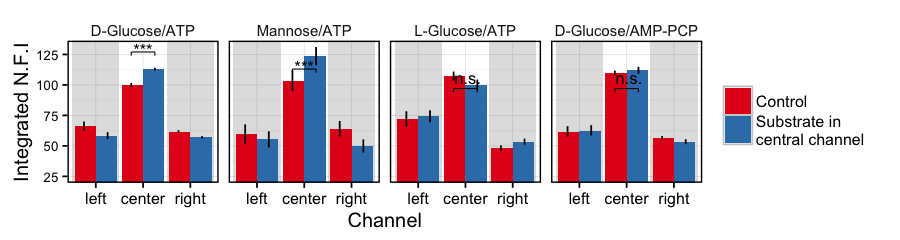

In [32]:
options(repr.plot.width = 7.5, repr.plot.height = 2)
integrated <- ggplot(data = bychannel_recap, 
                     aes(x=channel, y= smooth,fill = Experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Channel") +
    ylab("Integrated N.F.I") +
    facet_grid(. ~ Substrate,
       labeller = labeller(Substrate =c(dg = 'D-Glucose/ATP',lg = 'L-Glucose/ATP', mannose = 'Mannose/ATP',
                                       amppcp = "D-Glucose/AMP-PCP"))) +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) + 
  annotate("rect", xmin = 0.5, xmax = 1.5, ymin = 0, ymax = 150, alpha = .2) +
   annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = 150, alpha = .2) + 
    geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lo,ymax = hi ),position = position_dodge(1), width = 0) +
scale_fill_brewer(palette = 'Set1',labels = c("Control","Substrate in\ncentral channel")) +
coord_cartesian(ylim=c(25,131))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("dg","mannose","lg","amppcp"), Experiment = c("substrate","ctrl"), 
                      ann.x = c(0.75, 0.75), ann.xend = c(1.25,1.25), ann.y = c(0.0033, 0.0037),
                      ann.yend = c(0.0033,0.0037), ann.text = c("***","***"," n.s."," n.s."), 
                       ann.textoffset = c (2,2,9,9))

ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 1),]
#ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
ann.data$channel <- factor(c('left'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(1,1,1,1)
ann.data$y.offset <- c(127,113,97,97)


integrated <- integrated + 
    geom_segment(data = ann.data, size=.3,
                 aes(x = ann.x+x.offset, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset)) +
    geom_segment(data = ann.data, size = .3,
                 aes(x = ann.x+x.offset,xend=ann.x+x.offset,y=ann.y-3+y.offset,yend=ann.y+y.offset)) +
    geom_segment(data = ann.data, size =.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-3+y.offset,yend=ann.y+y.offset)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+.25+x.offset, y = ann.y+ann.textoffset+y.offset,label = ann.text))
                
print(integrated)

In [33]:
ann.data

,Substrate,Experiment,ann.x,ann.xend,ann.y,ann.yend,ann.text,ann.textoffset,channel,x.offset,y.offset
1,dg,substrate,0.75,1.25,0.0033,0.0033,***,2,left,1,127
2,mannose,ctrl,0.75,1.25,0.0037,0.0037,***,2,left,1,113
3,lg,substrate,0.75,1.25,0.0033,0.0033,n.s.,9,left,1,97
4,amppcp,ctrl,0.75,1.25,0.0037,0.0037,n.s.,9,left,1,97


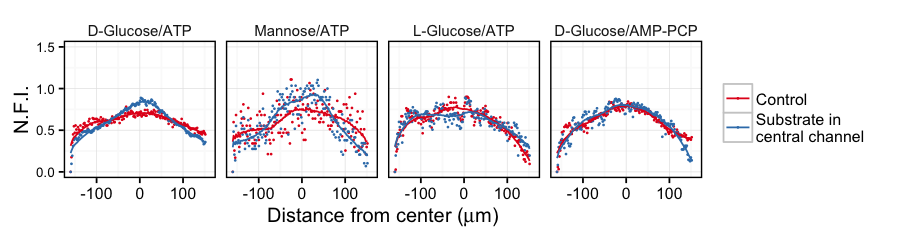

In [34]:
options(repr.plot.width = 7.5, repr.plot.height = 2)

raw <- ggplot(data = filter(fig3_recap),aes(x = distance-160,color = Experiment)) + 
    geom_point(aes(y = orig), size = 0.1) +
    geom_line(aes(y = smooth)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(dg = 'D-Glucose/ATP',lg = 'L-Glucose/ATP', mannose = 'Mannose/ATP',
                                       amppcp = "D-Glucose/AMP-PCP"))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=8),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
    annotate("rect", xmin = -160, xmax = -60, ymin = 0.00002, ymax = +.000092, alpha = .2) +
    annotate("rect", xmin = 60, xmax = 160, ymin = 0.00002, ymax = +.000092, alpha = .2) +
scale_color_brewer(palette = 'Set1',labels = c("Control","Substrate in\ncentral channel")) +
coord_cartesian(ylim=c(0,1.5))

    
print(raw)

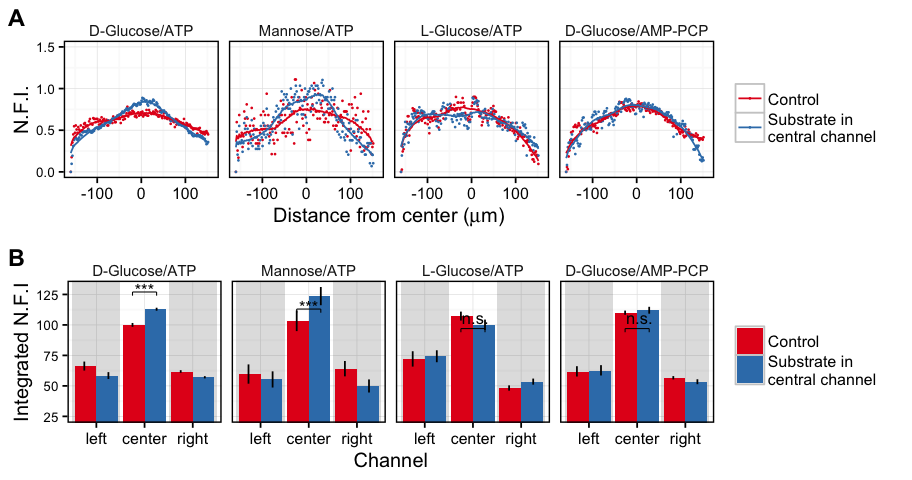

In [35]:
options(repr.plot.width = 7.6, repr.plot.height = 4)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 1)

In [174]:
ggsave("../img/FocusingExperimentPlot_v4.png",width = 7.6, height = 4)

In [ ]:
subset <- filter(bychannel_bs,Substrate == "dg", channel == "center")
control_LG <- filter(subset, Experiment == "ctrl")$concentration
atp_LG <- filter(subset, Experiment == "substrate")$concentration

In [ ]:
t.test(atp_LG,control_LG,alternative = 'greater')

In [ ]:
head(bychannel_recap)

In [ ]:
write.csv(bychannel_recap,"../newdata/bychannel_recap3.csv",quote=FALSE,sep=";")

In [ ]:
as.matrix(bychannel_recap[-1])

In [96]:
?mutate_each

summarise_each {dplyr},R Documentation
tbl,a tbl
funs,"List of function calls, generated by funs, or a character vector of function names."
"vars,...","Variables to include/exclude in mutate/summarise. You can use same specifications as in select. If missing, defaults to all non-grouping variables. For standard evaluation versions (ending in _) these can be either a list of expressions or a character vector."


In [167]:
bychannel_recap

,channel,Substrate,Experiment,orig,smooth,lo,hi
1,left,dg,ctrl,43.20716,42.97923,39.72115,46.59823
2,left,dg,substrate,34.0447,34.37444,32.64989,36.35473
3,left,mannose,ctrl,59.54114,59.24108,55.89352,62.09263
4,left,mannose,substrate,41.32049,41.39141,38.88644,44.0116
5,left,lg,ctrl,58.54272,58.06417,53.75525,62.37521
6,left,lg,substrate,60.47452,59.80191,55.58943,64.00887
7,left,amppcp,ctrl,50.32255,49.75344,46.64263,53.28839
8,left,amppcp,substrate,50.88069,50.25427,46.89434,53.60183
9,center,dg,ctrl,99.95041,100,97.08653,103.0944
10,center,dg,substrate,119.0986,118.7,115.0141,122.3568


In [175]:
write.csv(bychannel_recap,"../newdata/bychannel.csv")